**Description:** Contains solutions to the first two bullet points of Problem A.1 and the comparison of corresponding models (part of Problem A.2). Contributions: Bertoni 70%, Lombardi 30%.

### **Problem A.1: Variations/extensions of the basic MNIST diffusion model**

# Code provided

In [ ]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016,
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [ ]:
#Functions which will be used for all proposed models

def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

    losses = []

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader): #this is an iteration over evety batch created
            x = x.to(device) # the x is a tensor of as many images as the number of batche-size
            optimizer.zero_grad()
            loss = model.loss(x)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)

    # We used this commented out lines of code to save and download the learned parameters,
    # then we uploaded the files onto the GitHub repository
    '''
    # Save the EMA model's parameters
    #torch.save(ema_model.state_dict(), 'ema_model.pth')
    torch.save({
        'unet_state_dict': mnist_unet.state_dict(),
        'ddpm_state_dict': model.state_dict(),
        'ema_state_dict': ema_model.state_dict(),
    }, 'training_result.pth')

    from google.colab import files
    files.download('training_result.pth')
    '''

def reporter(model): # at the end of every epoch 10 samples of the model trained so far are printed
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()

In [ ]:
# In this cell we define the parameters common for all the models, we load the datasets (Train and Test) and we define the device

# Parameters
T = 1000
epochs = 100
batch_size = 256

# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform), batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=False, transform=transform), batch_size=batch_size, shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Point 1 (nn predict the noise scale)

In [ ]:
class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),(t.squeeze()/T))).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device) #this is actaully a tensor of as many random times in the interval as the shape of x0 (batch_size)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    # We define a new ELBO function which will give a better approximation of the likelihood in order to evaluate the model after the training

    def full_elbo(self, x0):

        batch_size = x0.shape[0]
        device = x0.device

        # Sample noise
        epsilon = torch.randn_like(x0)

        # Track cumulative ELBO terms
        elbo_terms = torch.zeros(batch_size, device=device)

        # Prior term: KL[q(x_T|x_0) || p(x_T)]
        # Since q(x_T | x_0) ~ N(0, I) and p(x_T) ~ N(0, I), this term is zero.

        for t in range(self.T, 1, -1):
            t_tensor = torch.full((batch_size, 1), t, device=device, dtype=torch.long)

            xt = self.forward_diffusion(x0, t_tensor, epsilon)

            # Compute q(x_{t-1} | x_t, x0) mean and std
            coef1 = (torch.sqrt(self.alpha_bar[t-1]) * self.beta[t]) / (1 - self.alpha_bar[t])
            coef2 = (torch.sqrt(self.alpha[t]) * (1 - self.alpha_bar[t-1])) / (1 - self.alpha_bar[t])
            mean_q = coef1 * x0 + coef2 * xt
            std_q = torch.sqrt(self.beta[t] * (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t]))

            # Reverse process p_theta(x_{t-1} | x_t)
            mean_p =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t_tensor))
            std_p = torch.sqrt(self.beta[t])

            # KL divergence, (L_{t-1})
            kl = 0.5 * torch.sum(((mean_q - mean_p) / std_p) ** 2 + (std_q / std_p) ** 2 - 1 - 2 * torch.log(std_q / std_p), dim=1)
            elbo_terms -= kl

        # Log likelihood term p_theta(x_0 | x_1), (L_0)
        # Assuming variance is sigma_p^2
        variance = self.beta[1]
        D = 28*28
        t_tensor = torch.full((batch_size, 1), 1, device=device, dtype=torch.long)
        xt = self.forward_diffusion(x0, t_tensor, epsilon)
        x0_reconstruction =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t_tensor))
        log_likelihood = -0.5 * ((x0 - x0_reconstruction) ** 2 / variance).sum(dim=1) - 0.5 * D * torch.log(2 * np.pi * variance)
        elbo_terms += log_likelihood

        return elbo_terms.mean()

    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


Training block (commented out):

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.6MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.06MB/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.00MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Training:   0%|          | 0/23500 [00:00<?, ?it/s]

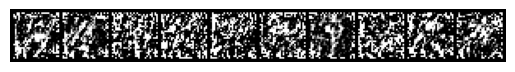

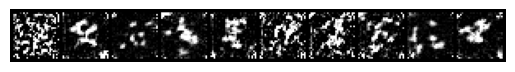

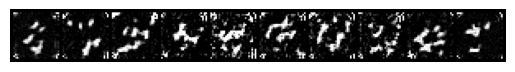

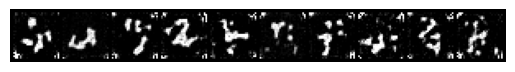

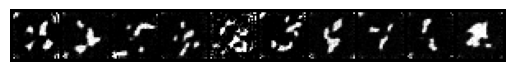

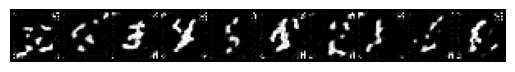

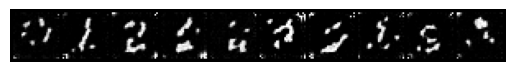

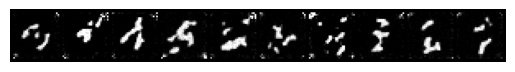

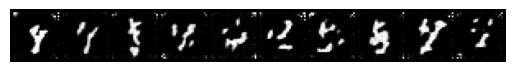

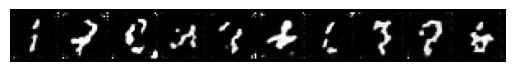

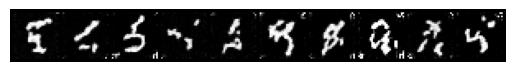

KeyboardInterrupt: 

In [ ]:
'''
# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


#Processing of the dataset

# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train and test dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform), batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=False, transform=transform), batch_size=batch_size, shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
train(model, optimizer, scheduler, dataloader_train,
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)
'''

Create model instance and load trained parameters:

In [ ]:
# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=1000).to(device)

# Initialize the EMA model
ema_steps = 10
ema_adjust = dataloader_train.batch_size * ema_steps / epochs
ema_decay = 1.0 - 0.995
ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

# Download the .pth file
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_eps.pth'
!wget -O training_result_eps.pth {raw_url}

# Load saved parameters
training_result = torch.load('training_result_eps.pth', map_location=device)
mnist_unet.load_state_dict(training_result['unet_state_dict'])
model.load_state_dict(training_result['ddpm_state_dict'])
ema_model.load_state_dict(training_result['ema_state_dict'])

--2025-01-15 17:02:34--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_eps.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8983849 (8.6M) [application/octet-stream]
Saving to: ‘training_result_eps.pth’

training_result_eps 100%[===================>]   8.57M  --.-KB/s    in 0.03s   

2025-01-15 17:02:34 (335 MB/s) - ‘training_result_eps.pth’ saved [8983849/8983849]



<ipython-input-49-afe8f2f19c09>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_result = torch.load('training_result_eps.pth', map_location=device)


<All keys matched successfully>

Plot 10 samples generated by the model:

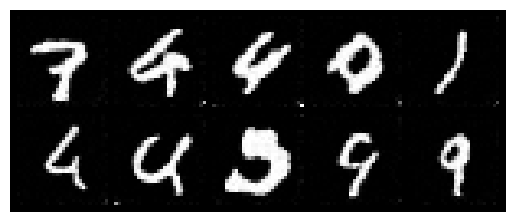

In [ ]:
# Set to evaluation mode
ema_model.module.eval()

# Generate samples
with torch.no_grad():
    samples = ema_model.module.sample((10, 28*28)).cpu()
    samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
    samples = samples.clamp(0.0, 1.0)

    # Visualization code
    grid = make_grid(samples.reshape(-1, 1, 28, 28), nrow=5)
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Point 1 (nn predict the mean)

In [ ]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM_mean(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM_mean, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),(t.squeeze()/T))).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  self.network(xt, t)
        std1 = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t])) * self.beta[t]), 0)
        std2 =  torch.where(t>0, torch.sqrt(self.beta[t]), 0)
        return mean + std2 * epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def elbo_mean_1(self, x0):

        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        epsilon = torch.randn_like(x0)

        xt = self.forward_diffusion(x0, t, epsilon)

        # We compute 2 different means at the time t (respectively using Equation (7) and Equation (10) from the paper)

        coef1 = (torch.sqrt(self.alpha_bar[t-1]) * self.beta[t]) / (1-self.alpha_bar[t])
        coef2 = (torch.sqrt(self.alpha[t]) * (1-self.alpha_bar[t-1])) / (1-self.alpha_bar[t])

        mean_t1 = coef1 * x0 + coef2 * xt
        mean_t2 = (1/torch.sqrt(self.alpha[t])) * (xt - ((self.beta[t] * epsilon) / torch.sqrt(1 - self.alpha_bar[t])))

        std1 = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t])) * self.beta[t]), 0)
        std2 =  torch.where(t>0, torch.sqrt(self.beta[t]), 0)

        l = (-nn.MSELoss(reduction='none')(mean_t1, self.network(xt, t))) * (1 / (2*(std1**2)))
        #return (-nn.MSELoss(reduction='mean')(mean_t1, self.network(xt, t))) #* (1 / (2*(std1**2)))
        return l.mean()

    def elbo_mean_2(self, x0):

        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        xt = self.forward_diffusion(x0, t, epsilon)
        eps_pred =  (- self.network(xt, t) * torch.sqrt(self.alpha[t]) + xt) * (torch.sqrt(1-self.alpha_bar[t]) / self.beta[t])

        return -nn.MSELoss(reduction='mean')(epsilon, eps_pred)

    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_mean_1(x0).mean()

In [ ]:
# Parameters
learning_rate = 1e-3

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model_mean = DDPM_mean(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model_mean.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
#train(model_mean, optimizer, scheduler, dataloader_train, epochs=epochs, device=device, ema=False, per_epoch_callback=reporter)

# Point 2 (Low-Discrepency sampler)

In [ ]:
# Here we define a new calss for the model based on the Low-Discrepency Sampler; the structure is the same as the standard model

class DDPM_LDs(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM_LDs, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def low_discrepancy_sampler(self, batch_size): # as described in appendix I.1 in the “Variational Diffusion Models” paper (adapted to the discrete case)

        # Sample a single random number from U(0, 1)
        u_0 = torch.rand(1).item()
        # Generate low-discrepancy timesteps
        t = torch.fmod(u_0 + torch.arange(0, batch_size, dtype=torch.float32) / batch_size, 1.0)
        t = (t * self.T).long() + 1  # Scale to [1, T] range
        #t = torch.clamp(torch.round((t * self.T)).long() + 1, self.T)  # Scale to [1, T] range
        return t.unsqueeze(-1).to(self.beta.device)

    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Use low-discrepancy sampler for time step t
        t = self.low_discrepancy_sampler(x0.shape[0])

        # Sample noise
        epsilon = torch.randn_like(x0)

        # Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    def full_elbo(self, x0):

        batch_size = x0.shape[0]
        device = x0.device

        # Sample noise
        epsilon = torch.randn_like(x0)

        # Track cumulative ELBO terms
        elbo_terms = torch.zeros(batch_size, device=device)

        # Prior term: KL[q(x_T|x_0) || p(x_T)]
        # Since q(x_T | x_0) ~ N(0, I) and p(x_T) ~ N(0, I), this term is zero.

        for t in range(self.T, 1, -1):
            t_tensor = torch.full((batch_size, 1), t, device=device, dtype=torch.long)

            # Forward diffusion
            xt = self.forward_diffusion(x0, t_tensor, epsilon)

            # Compute q(x_{t-1} | x_t, x0) mean and std
            coef1 = (torch.sqrt(self.alpha_bar[t-1]) * self.beta[t]) / (1 - self.alpha_bar[t])
            coef2 = (torch.sqrt(self.alpha[t]) * (1 - self.alpha_bar[t-1])) / (1 - self.alpha_bar[t])
            mean_q = coef1 * x0 + coef2 * xt
            std_q = torch.sqrt(self.beta[t] * (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t]))

            # Reverse process p_theta(x_{t-1} | x_t)
            mean_p =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t_tensor))
            std_p = torch.sqrt(self.beta[t])

            # KL divergence, i.e. L_{t-1}
            kl = 0.5 * torch.sum(((mean_q - mean_p) / std_p) ** 2 + (std_q / std_p) ** 2 - 1 - 2 * torch.log(std_q / std_p), dim=1)
            elbo_terms -= kl

        # Log likelihood term p_theta(x_0 | x_1), i.e. L_0
        # Assuming variance is sigma_p^2
        variance = self.beta[1]
        D = 28*28
        t_tensor = torch.full((batch_size, 1), 1, device=device, dtype=torch.long)
        xt = self.forward_diffusion(x0, t_tensor, epsilon)
        x0_reconstruction =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t_tensor))
        log_likelihood = -0.5 * ((x0 - x0_reconstruction) ** 2 / variance).sum(dim=1) - 0.5 * D * torch.log(2 * np.pi * variance)
        elbo_terms += log_likelihood

        return elbo_terms.mean()


    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()

Training block (commented out):

In [ ]:
'''
# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


#Processing of the dataset

# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train and test dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform), batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=False, transform=transform), batch_size=batch_size, shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM_LDs(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
train(model, optimizer, scheduler, dataloader_train,
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)
'''

In [ ]:
# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model_2 = DDPM_LDs(mnist_unet, T=1000).to(device)

# Initialize the EMA model
ema_steps = 10
ema_adjust = dataloader_train.batch_size * ema_steps / epochs
ema_decay = 1.0 - 0.995
ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
ema_model_2 = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

# Download the .pth file
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_LDs.pth'
!wget -O training_result_LDs.pth {raw_url}

# Load saved parameters
training_result = torch.load('training_result_LDs.pth', map_location=device)
mnist_unet.load_state_dict(training_result['unet_state_dict'])
model_2.load_state_dict(training_result['ddpm_state_dict'])
ema_model_2.load_state_dict(training_result['ema_state_dict'])

--2025-01-15 17:10:42--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_LDs.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8984213 (8.6M) [application/octet-stream]
Saving to: ‘training_result_LDs.pth’

training_result_LDs 100%[===================>]   8.57M  --.-KB/s    in 0.02s   

2025-01-15 17:10:43 (362 MB/s) - ‘training_result_LDs.pth’ saved [8984213/8984213]



<ipython-input-58-76235a853be3>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_result = torch.load('training_result_LDs.pth', map_location=device)


<All keys matched successfully>

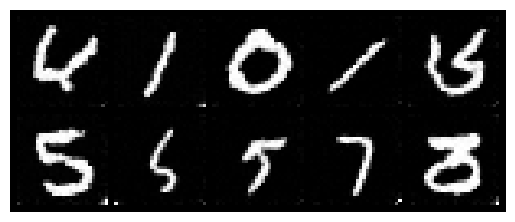

In [ ]:
# Set to evaluation mode
ema_model_2.module.eval()

# Generate samples
with torch.no_grad():
    samples = ema_model_2.module.sample((10, 28*28)).cpu()
    samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
    samples = samples.clamp(0.0, 1.0)

    # Visualization code
    grid = make_grid(samples.reshape(-1, 1, 28, 28), nrow=5)
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Point 2 (Importance Sampling)

In [ ]:
# Here we define a new calss for the model based on Importance Sampling; again, the structure is the same as the standard model

class DDPM_IS(nn.Module):
    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        super(DDPM_IS, self).__init__()
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)
        self.T = T
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

        self.loss_history = torch.zeros((T, 10), device=self.beta.device)  # Store 10 recent losses for each timestep

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon

    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def update_loss_history(self, t, loss):
        for i, step in enumerate(t.squeeze().tolist()):
            self.loss_history[step - 1] = torch.cat((self.loss_history[step - 1, 1:], loss[i].unsqueeze(0).to(self.loss_history.device))).to(self.loss_history.device)
    #For every very time we have in the tensor t given in input we update the loss history (t is a tensor because the code is handling each batch simoultaneously)

    def compute_importance_weights(self):
        mean_squared_losses = (self.loss_history**2).mean(dim=1)
        weights = torch.sqrt(mean_squared_losses)
        normalized_weights = weights / weights.sum()
        return normalized_weights

    def elbo_IS(self, x0, step=0):
        # Determine if we need to sample uniformly or use importance sampling

        if  torch.any(self.loss_history == 0).item():
        #if step < self.T * 10:
            t = torch.randint(1, self.T, (x0.shape[0], 1)).to(x0.device)
            weights = None
        else:
            # Compute weights and sample t according to importance sampling
            weights = self.compute_importance_weights()
            t = torch.multinomial(weights, x0.shape[0], replacement=True).unsqueeze(-1) + 1

        # Compute probabilities for sampled t
        p_t = weights[t.squeeze() - 1] if weights is not None else 1 / self.T

        # Sample noise
        epsilon = torch.randn_like(x0)

        # Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        # Compute the per-sample loss
        per_sample_loss = nn.MSELoss(reduction='none')(epsilon, self.network(xt, t)).mean(dim=1)
        reweighted_loss = (per_sample_loss / p_t).mean() if weights is not None else per_sample_loss.mean()

        # Update the loss history
        self.update_loss_history(t, per_sample_loss.detach())

        return -reweighted_loss

    def full_elbo(self, x0):

        batch_size = x0.shape[0]
        device = x0.device

        # Sample noise
        epsilon = torch.randn_like(x0)

        # Track cumulative ELBO terms
        elbo_terms = torch.zeros(batch_size, device=device)

        # Prior term: KL[q(x_T|x_0) || p(x_T)]
        # Since q(x_T | x_0) ~ N(0, I) and p(x_T) ~ N(0, I), this term is zero.

        for t in range(self.T, 1, -1):
            t_tensor = torch.full((batch_size, 1), t, device=device, dtype=torch.long)

            # Forward diffusion
            xt = self.forward_diffusion(x0, t_tensor, epsilon)

            # Compute q(x_{t-1} | x_t, x0) mean and std
            coef1 = (torch.sqrt(self.alpha_bar[t-1]) * self.beta[t]) / (1 - self.alpha_bar[t])
            coef2 = (torch.sqrt(self.alpha[t]) * (1 - self.alpha_bar[t-1])) / (1 - self.alpha_bar[t])
            mean_q = coef1 * x0 + coef2 * xt
            std_q = torch.sqrt(self.beta[t] * (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t]))

            # Reverse process p_theta(x_{t-1} | x_t)
            mean_p =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t_tensor))
            std_p = torch.sqrt(self.beta[t])

            # KL divergence, i.e. L_{t-1}
            kl = 0.5 * torch.sum(((mean_q - mean_p) / std_p) ** 2 + (std_q / std_p) ** 2 - 1 - 2 * torch.log(std_q / std_p), dim=1)
            elbo_terms -= kl

        # Log likelihood term p_theta(x_0 | x_1), i.e. L_0
        # Assuming variance is sigma_p^2
        variance = self.beta[1]
        D = 28*28
        t_tensor = torch.full((batch_size, 1), 1, device=device, dtype=torch.long)
        xt = self.forward_diffusion(x0, t_tensor, epsilon)
        x0_reconstruction =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t_tensor))
        log_likelihood = -0.5 * ((x0 - x0_reconstruction) ** 2 / variance).sum(dim=1) - 0.5 * D * torch.log(2 * np.pi * variance)
        elbo_terms += log_likelihood

        return elbo_terms.mean()

    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_IS(x0)


Training block:

In [ ]:
'''
# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model_3 = DDPM_IS(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


# Call training loop
train(model_3, optimizer, scheduler, dataloader_train,
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)
'''

Create model instance and load trained parameters, than plot 5 samples generated by the model:

In [ ]:
# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model_3 = DDPM_IS(mnist_unet, T=1000).to(device)

# Initialize the EMA model
ema_steps = 10
ema_adjust = dataloader_train.batch_size * ema_steps / epochs
ema_decay = 1.0 - 0.995
ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
ema_model_3 = ExponentialMovingAverage(model_3, device=device, decay=1.0 - ema_alpha)

# Download the pth file
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_IS.pth'
!wget -O training_result_IS.pth {raw_url}

# Load saved parameters
training_result = torch.load('training_result_IS.pth', map_location=device)
mnist_unet.load_state_dict(training_result['unet_state_dict'])
model_3.load_state_dict(training_result['ddpm_state_dict'])
ema_model_3.load_state_dict(training_result['ema_state_dict'])


--2025-01-15 17:13:18--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_IS.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8984213 (8.6M) [application/octet-stream]
Saving to: ‘training_result_IS.pth’

training_result_IS. 100%[===================>]   8.57M  --.-KB/s    in 0.02s   

2025-01-15 17:13:19 (351 MB/s) - ‘training_result_IS.pth’ saved [8984213/8984213]



<ipython-input-62-3f87a0da7159>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_result = torch.load('training_result_IS.pth', map_location=device)


<All keys matched successfully>

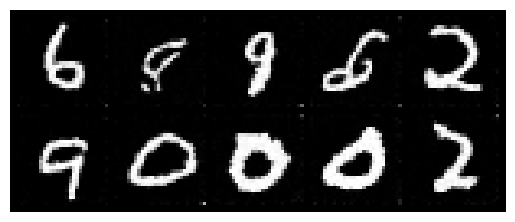

In [ ]:
# Set to evaluation mode
ema_model_3.module.eval()

# Generate samples
with torch.no_grad():
    samples = ema_model_3.module.sample((10, 28*28)).cpu()  # .module if using AveragedModel
    samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
    samples = samples.clamp(0.0, 1.0)

    # Visualization code
    grid = make_grid(samples.reshape(-1, 1, 28, 28), nrow=5)
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Problem A.2:Quantitative comparisons

## Computation of Likelihood and comparisons

In [ ]:
# First, we try to evaluate our trained model by computing the log-likelihood. Since computing the log-likelihood is infeasible
# in the context of ddpms, we compute instead the ELBO, which gives a lower bound for the log-likelihood. Is this a good parameter for evaluating the model?

def compute_log_likelihood(model, dataloader, device):
    model.eval()
    log_likelihoods = []

    with torch.no_grad():
        i = 0
        for x, _ in dataloader:
            i += 1
            x = x.to(device)
            elbo = model.full_elbo(x)
            print(f'Batch {i: 2d}/{len(dataloader)}, Avarage ELBO: {elbo: 2.4e}')
            log_likelihoods.append(elbo.item())  # ELBO as an approximation of log-likelihood

    # Compute average elbo across all samples
    return np.mean(log_likelihoods)

In [ ]:
print('Computing the log-likelihood on the train set...')
log_likelihood_train = compute_log_likelihood(ema_model.module, dataloader_train, device)

print('\nComputing the log-likelihood on the test set...')
log_likelihood_test = compute_log_likelihood(ema_model.module, dataloader_test, device)

print(f"\nLog-Likelihood of the model (using the train): {log_likelihood_train}")
print(f"Log-Likelihood of the model (using the test): {log_likelihood_test}")

Batch  1/235, Avarage ELBO:  1.7450e+03
Batch  2/235, Avarage ELBO:  1.7481e+03
Batch  3/235, Avarage ELBO:  1.7480e+03
Batch  4/235, Avarage ELBO:  1.7410e+03
Batch  5/235, Avarage ELBO:  1.7503e+03
Batch  6/235, Avarage ELBO:  1.7467e+03
Batch  7/235, Avarage ELBO:  1.7466e+03
Batch  8/235, Avarage ELBO:  1.7163e+03
Batch  9/235, Avarage ELBO:  1.7437e+03
Batch  10/235, Avarage ELBO:  1.7500e+03
Batch  11/235, Avarage ELBO:  1.7307e+03


KeyboardInterrupt: 

In [ ]:
log_likelihood_train = compute_log_likelihood(ema_model_2.module, dataloader_train, device)
log_likelihood_test = compute_log_likelihood(ema_model_2.module, dataloader_test, device)
print(f"Log-Likelihood of the model (using the train)(variant with Low-Discrepency Sampler): {log_likelihood_train}")
print(f"Log-Likelihood of the model (using the test)(variant with Low-Discrepency Sampler): {log_likelihood_test}")

In [ ]:
log_likelihood_train = compute_log_likelihood(ema_model_3.module, dataloader_train, device)
log_likelihood_test = compute_log_likelihood(ema_model_3.module, dataloader_test, device)
print(f"Log-Likelihood of the model (variant with Importance Sampling) (using the train): {log_likelihood_train}")
print(f"Log-Likelihood of the model (variant with Importance Sampling)(using the test): {log_likelihood_test}")

Running the code above to compute the ELBO on the test set for the different trained models, we obtained the following results:

\begin{array}{cc}
\hline
\text{Model} & \text{ELBO Test} & \text{ELBO Train} \\
\hline
\text{DDPM} & 1.7352 \cdot 10^3 & 1.7355 \cdot 10^3\\
\text{DDPM LDs} &  1.7360 \cdot 10^3 & 1.7348 \cdot 10^3\\
\text{DDPM IS} &  1.7411 \cdot 10^3 & 1.7409 \cdot 10^3 \\
\hline
\end{array}


## Computation of Inception score and comparisons

In [ ]:
# MNIST classifier model
from torch.optim.lr_scheduler import StepLR

cnn_model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # The shape becomes (14, 14)
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # The shape becomes (7, 7)
    nn.Dropout(0.4),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # The shape becomes (4, 4)
    nn.ReLU(),
    nn.AvgPool2d(4),
    nn.Flatten(),
    nn.Linear(128, 10),
)
# Move the model to the device
cnn_model.to(device)
print(cnn_model)
#print(sum(p.numel() for p in cnn_model.parameters() if p.requires_grad))

def train_cnn(model, optimizer, train_loader, val_loader, batch_size, epochs, device):
    model.to(device)

    step_size = round(epochs * 3/4)  # Reduce LR during training
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1, verbose=True)

    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        losses = []
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.view(-1, 1, 28, 28))
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f'Train epoch: {epoch + 1}  Loss: {np.mean(losses):.4f}')

        val_accuracy = evaluate_cnn(model, val_loader, device)

        scheduler.step()

def evaluate_cnn(model, loader, device, test_flag=False):
    model.eval()
    total_loss = 0
    correct = 0

    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data.view(-1, 1, 28, 28))
            total_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    average_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    if not test_flag:
        print(f'Evaluation loss: {average_loss:.4f}, 'f'Accuracy: {correct}/{len(loader.dataset)} ({accuracy*100:.4f}%)')
    else:
        print(f'Accuracy on the test set: {correct}/{len(loader.dataset)} ({accuracy*100:.2f}%)')

    return accuracy

Sequential(
  (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.4, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.4, inplace=False)
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Dropout(p=0.4, inplace=False)
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): ReLU()
  (13): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Train MNIST classifier (commented out)

'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform), batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=False, transform=transform), batch_size=batch_size, shuffle=True)
# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
train_cnn(cnn_model, optimizer, dataloader_train, dataloader_test, batch_size=64, epochs=10, device=device)

torch.save(cnn_model.state_dict(), 'training_result_cnn.pth')

from google.colab import files
files.download('training_result_cnn.pth')  # Replace with your filename
'''

# Load learned parameters

# Download the pth file
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_cnn.pth'
!wget -O training_result_cnn.pth {raw_url}

# Load saved parameters
training_result = torch.load('training_result_cnn.pth', map_location=device)
cnn_model.load_state_dict(training_result)

--2025-01-15 17:18:28--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/training_result_cnn.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 663840 (648K) [application/octet-stream]
Saving to: ‘training_result_cnn.pth’

training_result_cnn 100%[===================>] 648.28K  --.-KB/s    in 0.007s  

2025-01-15 17:18:28 (93.2 MB/s) - ‘training_result_cnn.pth’ saved [663840/663840]



<ipython-input-67-5995c59e467e>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_result = torch.load('training_result_cnn.pth', map_location=device)


<All keys matched successfully>

In [ ]:
# Assess quality of the classifier by computing the accuracy on the test set:
_ = evaluate_cnn(cnn_model, dataloader_test, device, test_flag=True)

Accuracy on the test set: 9906/10000 (99.06%)


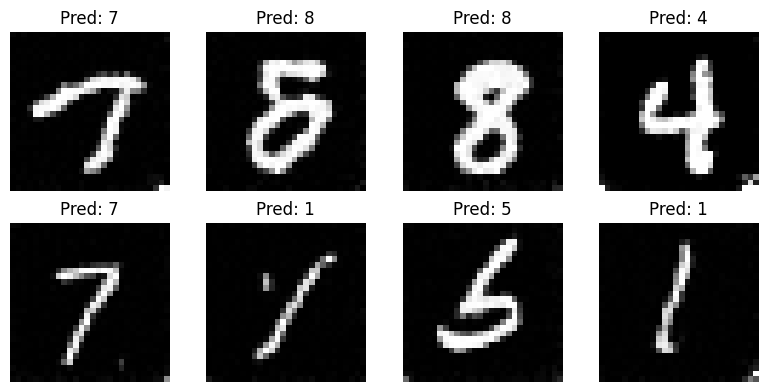

In [ ]:
# Example of usage of the classifier: generate samples using the DDPM model and classify them with cnn_model

def classify_samples(num_samples=8, DDPM_model=model, classifier=cnn_model, device=device):
    DDPM_model.eval()
    cnn_model.eval()

    with torch.no_grad():
        # Generate samples
        samples = DDPM_model.sample((num_samples, 28*28)).to(device)

        # Reshape and classify samples
        samples_reshaped = samples.reshape(-1, 1, 28, 28)
        output = classifier(samples_reshaped)
        pred = output.argmax(dim=1)

        # Move samples to CPU for visualization
        samples = samples.cpu()
        samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
        samples = samples.clamp(0.0, 1.0)
        samples_np = samples.numpy()

        # Set up the plot
        n_cols = min(num_samples, 4)  # Set maximum columns for readability
        n_rows = (num_samples + n_cols - 1) // n_cols  # Compute number of rows needed

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
        axes = axes.flatten()  # Flatten in case of multiple rows

        for idx in range(num_samples):
            ax = axes[idx]
            img = samples_np[idx].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Pred: {pred[idx].item()}')

        # Hide any remaining axes if num_samples < n_rows * n_cols
        for idx in range(num_samples, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

classify_samples()

In [ ]:
# Now we evluate the model using the Inception Score: the idea is to first generate a certain number of samples from the trained model, then using a classifier (a CNN defined by us,
# or a downloaded one like Inception_v3 (but this is made for other images)) and then calculate the condition probabilities p(y|x) and the marginal p(y) (where y are the possibile classes)
# In the end we can obtain IS = (exp(sum(KL(p(y) || p(y|x_i)))))) and then calculate its mean and std

def inception_score(samples, classifier, splits=50):

    classifier.eval()
    with torch.no_grad():
        # Get predicted class probabilities for all samples
        probs = F.softmax(classifier(samples), dim=1).cpu().numpy()

    # Split the probabilities into chunks
    split_scores = []
    N = len(probs)
    for k in range(splits):
        part = probs[k * (N // splits): (k + 1) * (N // splits), :]
        # Compute the marginal class distribution p(y)
        p_y = np.mean(part, axis=0)
        # Compute the KL divergence for each sample and average
        kl_divs = part * (np.log(part + 1e-6) - np.log(p_y + 1e-6))
        split_scores.append(np.exp(np.mean(np.sum(kl_divs, axis=1))))

    # Return mean and standard deviation of the IS
    return np.mean(split_scores), np.std(split_scores)

In [ ]:
generated_samples = ema_model.module.sample((10000, 28 * 28)).reshape(-1, 1, 28, 28).to(device) #NB: generating so many samples takes ≈7min with GPU

mean_is, std_is = inception_score(generated_samples, cnn_model)
print(f"Inception Score (First Model): {mean_is} ± {std_is}")

In [ ]:
generated_samples_2 = ema_model_2.module.sample((10000, 28 * 28)).reshape(-1, 1, 28, 28).to(device) #NB: generating so many samples takes ≈7min with GPU

mean_is, std_is = inception_score(generated_samples_2, cnn_model)
print(f"Inception Score (with Low-Discrepency Sampler): {mean_is} ± {std_is}")

Inception Score (with Low-Discrepency Sampler): 7.218103408813477 ± 0.22049632668495178


In [ ]:
generated_samples_3 = ema_model_3.module.sample((10000, 28 * 28)).reshape(-1, 1, 28, 28).to(device) #NB: generating so many samples takes ≈7min with GPU

mean_is, std_is = inception_score(generated_sample_3, cnn_model)
print(f"Inception Score (with Importance Sampling): {mean_is} ± {std_is}")

Running the code above to compute the IS score on the test set for the different trained models, we obtained the following results:

\begin{array}{cc}
\hline
\text{Model} & \text{IS} \\
\hline
\text{DDPM} &  7.2212 \pm 0.1919\\
\text{DDPM LDs} &  7.2426 \pm 0.1835\\
\text{DDPM IS} &  7.3086 \pm 0.2025\\
\hline
\end{array}


## Computation of FID score and comparisons

In [ ]:
# This is a function which computes the FID score given 2 inputs: real features and generated features

def calculate_fid(real_features, generated_features):
    """
    Computes the Fréchet Inception Distance (FID) between two sets of features.

    Parameters:
    - real_features: numpy array of shape (N, D) with features from real images.
    - generated_features: numpy array of shape (N, D) with features from generated images.

    Returns:
    - fid: Fréchet Inception Distance.
    """
    # Compute means and covariances
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(generated_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(generated_features, rowvar=False)

    # Compute the squared difference of means
    diff = mu_real - mu_gen

    # Compute the covariance matrix product
    covmean, _ = sqrtm(sigma_real @ sigma_gen, disp=False)

    # FID formula
    fid = np.linalg.norm(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

In [ ]:
real_features = (torch.empty(size = (0, 10))).to(device)
for data, _ in dataloader_test:
  data = data.to(device)
  output = cnn_model(data.view(-1, 1, 28, 28))
  real_features = torch.cat((real_features,output),0 )

real_features = real_features.cpu().detach().numpy()

generated_features = cnn_model(generated_samples).cpu().detach().numpy()
generated_features_2 = cnn_model(generated_samples_2).cpu().detach().numpy()
generated_features_3 = cnn_model(generated_samples_3).cpu().detach().numpy()

fid_score = calculate_fid(real_features, generated_features)
fid_score_2 = calculate_fid(real_features, generated_features_2)
fid_score_3 = calculate_fid(real_features, generated_features_3)

print(f"FID Score (First Model): {fid_score}")
print(f"FID Score (with Low-Discrepency Sampler): {fid_score_2}")
print(f"FID Score (with Importance Sampling): {fid_score_3}")

Running the code above to compute the FID on the test set for the different trained models, we obtained the following results:

\begin{array}{cc}
\hline
\text{Model} & \text{FID} \\
\hline
\text{DDPM} &  8.1010\\
\text{DDPM LDs} &  8.8860\\
\text{DDPM IS} &  10.3433\\
\hline
\end{array}


## Loss comparison

In [ ]:
from google.colab import files
import pickle

# Download the pickle file from the raw URL
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/losses_eps.pkl'
!wget -O losses_eps.pkl {raw_url}
with open('losses_eps.pkl', 'rb') as file:
    losses_eps = pickle.load(file)

# Download the pickle file from the raw URL
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/losses_IS.pkl'
!wget -O losses_IS.pkl {raw_url}
with open('losses_IS.pkl', 'rb') as file:
    losses_IS = pickle.load(file)

# Download the pickle file from the raw URL
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/losses_LDs.pkl'
!wget -O losses_LDs.pkl {raw_url}
with open('losses_LDs.pkl', 'rb') as file:
    losses_LDs = pickle.load(file)

--2025-01-16 17:53:29--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/losses_eps.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211589 (207K) [application/octet-stream]
Saving to: ‘losses_eps.pkl’

losses_eps.pkl      100%[===================>] 206.63K  --.-KB/s    in 0.04s   

2025-01-16 17:53:30 (5.72 MB/s) - ‘losses_eps.pkl’ saved [211589/211589]

--2025-01-16 17:53:30--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/losses_IS.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [ ]:
std_1 =np.std(losses_eps)
std_2 = np.std(losses_IS)
std_3 = np.std(losses_LDs)

print([std_1, std_2, std_3])

0.09592766890984786
0.07276534992687213
0.06458689502967761


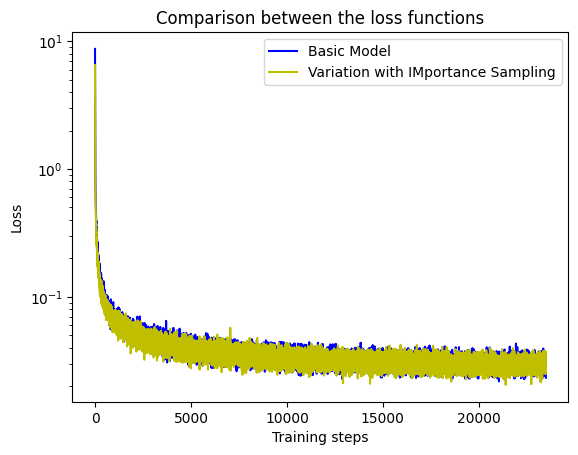

In [ ]:
plt.figure()
plt.title('Comparison between the loss functions')
plt.xlabel('Training steps')
plt.ylabel('Loss')

plt.semilogy(losses_eps, 'b', alpha=1)
plt.semilogy(losses_IS,'y', alpha=1)
plt.legend(['Basic Model', 'Variation with IMportance Sampling'])
plt.show()

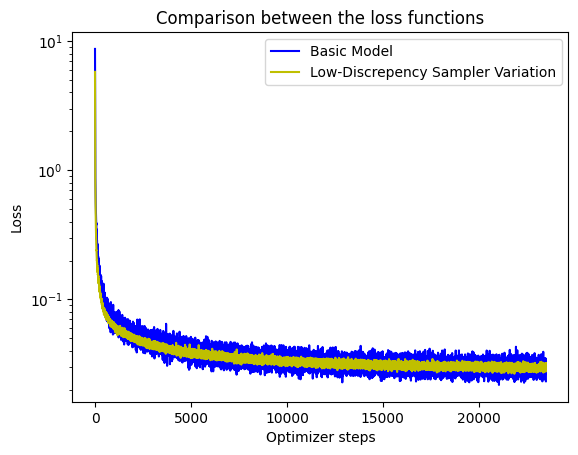

In [ ]:
plt.figure()
plt.title('Comparison between the loss functions')
plt.xlabel('Training steps')
plt.ylabel('Loss')


plt.semilogy(losses_eps, 'b', alpha=1)
plt.semilogy(losses_LDs,'y', alpha=1)
plt.legend(['Basic Model', 'Low-Discrepency Sampler Variation'])
plt.show()